# Import Necessary Libraries

In [2]:
!pip install lifetimes
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# Import Dataset

In [3]:
online_retail = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = online_retail.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


# Find Outlier and then replace with trhesholds

In [26]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99, 1]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,98%,99%,100%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,-2.0000,1.0000,1.0000,1.0000,2.0000,2.0000,3.0000,5.0000,8.0000,12.0000,24.0000,29.0000,72.0000,100.0000,80995.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,0.1900,0.4200,0.6300,0.8500,1.2500,1.6500,2.0800,2.5500,3.7500,4.9500,7.9500,9.9500,14.9500,18.0000,38970.0000,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,12415.0000,12626.0000,12876.0000,13536.0000,14159.0000,14659.0000,15152.0000,15805.0000,16493.0000,17095.0000,17719.0000,17905.0000,18119.0000,18212.0000,18287.0000,18287.0000


In [50]:
def outlier_thresholds(dataframe, variable):
  quartile1 = dataframe[variable].quantile(0.01)
  quartile3 = dataframe[variable].quantile(0.99)
  interquartile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquartile_range
  low_limit = quartile1 - 1.5 * interquartile_range
  return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Data Preprocessing

In [63]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011,12,11)

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000
TotalPrice,397885.0000,20.6298,51.8285,0.0010,4.6800,11.8000,19.8000,3268.5750


# Preparation of lifetime data structure

In [81]:
cltv_df = df.groupby(["Customer ID"]).agg({"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                          lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                          'Invoice': lambda Invoice: Invoice.nunique(),
                                          'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[cltv_df["frequency"] > 1]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [83]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100


# Set the BG/NBD Model

In [86]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.06, alpha: 9.31, b: 1.13, r: 1.78>

# Who are the 10 customers we expect the most to purchase 1 week?

In [91]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.3559
14911.0000   3.2285
17841.0000   2.0018
13089.0000   1.5860
14606.0000   1.5087
15311.0000   1.4771
12971.0000   1.3992
14646.0000   1.2439
13408.0000   1.0148
18102.0000   0.9967
dtype: float64

In [92]:
bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.3559
14911.0000   3.2285
17841.0000   2.0018
13089.0000   1.5860
14606.0000   1.5087
15311.0000   1.4771
12971.0000   1.3992
14646.0000   1.2439
13408.0000   1.0148
18102.0000   0.9967
dtype: float64

In [93]:
cltv_df["expected_purc_1_week"] = bgf.predict(1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
cltv_df["expected_purc_1_week"].sum()

455.8798678583038

In [94]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1407
12348.0000,40.2857,51.2857,4,442.6950,0.0912
12352.0000,37.1429,42.4286,8,219.5425,0.1851
12356.0000,43.1429,46.5714,3,937.1433,0.0834
12358.0000,21.2857,21.5714,2,575.2100,0.1190


# Who are the 10 customers we expect the most to purchase 1 month?

In [95]:
bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   13.4050
14911.0000   12.8962
17841.0000    7.9962
13089.0000    6.3349
14606.0000    6.0263
15311.0000    5.9002
12971.0000    5.5890
14646.0000    4.9685
13408.0000    4.0533
18102.0000    3.9812
dtype: float64

In [96]:
cltv_df["expected_purc_1_month"] = bgf.predict(4, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
cltv_df["expected_purc_1_month"].sum()

1817.9796518648423

In [97]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1407,0.5617
12348.0000,40.2857,51.2857,4,442.6950,0.0912,0.3643
12352.0000,37.1429,42.4286,8,219.5425,0.1851,0.7391
12356.0000,43.1429,46.5714,3,937.1433,0.0834,0.3330
12358.0000,21.2857,21.5714,2,575.2100,0.1190,0.4740


# Who are the 10 customers we expect the most to purchase 3 month?

In [99]:
bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   40.0742
14911.0000   38.5532
17841.0000   23.9042
13089.0000   18.9371
14606.0000   18.0153
15311.0000   17.6382
12971.0000   16.7075
14646.0000   14.8504
13408.0000   12.1168
18102.0000   11.9005
dtype: float64

In [100]:
cltv_df["expected_purc_3_month"] = bgf.predict(4*3, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])
cltv_df["expected_purc_3_month"].sum()

5415.853456253086

# Evaluation of predict results

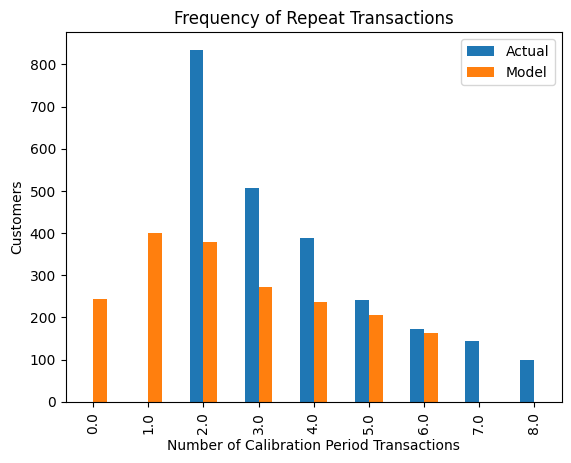

In [102]:
plot_period_transactions(bgf)
plt.show()

# Set the Gamma-Gamma Model

In [103]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"], cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

# Expected Average Profit

In [104]:
ggf.conditional_expected_average_profit(cltv_df["frequency"], cltv_df["monetary"]).head()

Customer ID
12347.0000   631.9123
12348.0000   463.7460
12352.0000   224.8868
12356.0000   995.9989
12358.0000   631.9022
dtype: float64

In [105]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"], cltv_df["monetary"])

In [106]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1407,0.5617,1.6780,631.9123
12348.0000,40.2857,51.2857,4,442.6950,0.0912,0.3643,1.0880,463.7460
12352.0000,37.1429,42.4286,8,219.5425,0.1851,0.7391,2.2068,224.8868
12356.0000,43.1429,46.5714,3,937.1433,0.0834,0.3330,0.9939,995.9989
12358.0000,21.2857,21.5714,2,575.2100,0.1190,0.4740,1.4089,631.9022


# Calculating CLTV with BG/NBD Model and Gamma-Gamma Model

In [107]:
cltv = ggf.customer_lifetime_value(bgf,
                            cltv_df["frequency"],
                            cltv_df["recency"],
                            cltv_df["T"],
                            cltv_df["monetary"],
                            time=3, # month
                            freq="W",
                            discount_rate=0.01
                            )

In [109]:
cltv.head()

Customer ID
12347.0000   1128.6323
12348.0000    536.9851
12352.0000    528.1884
12356.0000   1053.5665
12358.0000    947.1019
Name: clv, dtype: float64

In [110]:
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1128.6323
1,12348.0000,536.9851
2,12352.0000,528.1884
3,12356.0000,1053.5665
4,12358.0000,947.1019


In [111]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1407,0.5617,1.6780,631.9123
12348.0000,40.2857,51.2857,4,442.6950,0.0912,0.3643,1.0880,463.7460
12352.0000,37.1429,42.4286,8,219.5425,0.1851,0.7391,2.2068,224.8868
12356.0000,43.1429,46.5714,3,937.1433,0.0834,0.3330,0.9939,995.9989
12358.0000,21.2857,21.5714,2,575.2100,0.1190,0.4740,1.4089,631.9022


In [112]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [113]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
0,12347.0000,52.1429,52.5714,7,615.7143,0.1407,0.5617,1.6780,631.9123,1128.6323
1,12348.0000,40.2857,51.2857,4,442.6950,0.0912,0.3643,1.0880,463.7460,536.9851
2,12352.0000,37.1429,42.4286,8,219.5425,0.1851,0.7391,2.2068,224.8868,528.1884
3,12356.0000,43.1429,46.5714,3,937.1433,0.0834,0.3330,0.9939,995.9989,1053.5665
4,12358.0000,21.2857,21.5714,2,575.2100,0.1190,0.4740,1.4089,631.9022,947.1019


In [114]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2439,4.9685,14.8504,3654.8148,57772.0482
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9967,3.9812,11.9005,3870.9969,49035.0124
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7809,3.1119,9.2547,3196.4361,31471.2472
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3907,1.5603,4.6623,5772.1782,28644.1480
1257,14911.0000,53.1429,53.4286,201,691.7101,3.2285,12.8962,38.5532,692.3264,28411.5289
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7692,3.0723,9.1835,2874.1987,28095.8369
874,14156.0000,51.5714,53.1429,55,2104.0267,0.9047,3.6138,10.8026,2110.7542,24270.9807
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5210,2.0810,6.2204,2950.5801,19536.2640
1754,16000.0000,0.0000,0.4286,3,2335.1200,0.4784,1.8938,5.5685,2479.8048,14675.7446
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4897,1.9560,5.8460,2223.8850,13838.3054


# Creation of Segmentation

In [116]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [117]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1407,0.5617,1.6780,631.9123,1128.6323,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0912,0.3643,1.0880,463.7460,536.9851,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1851,0.7391,2.2068,224.8868,528.1884,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0834,0.3330,0.9939,995.9989,1053.5665,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1190,0.4740,1.4089,631.9022,947.1019,A


In [118]:
cltv_final.groupby("segment").agg({"count", "sum", "mean"})

Customer ID                     recency                        T                  frequency             monetary                   expected_purc_1_week                expected_purc_1_month                expected_purc_3_month                 expected_average_profit                         clv                   
               mean count           sum    mean count        sum    mean count        sum      mean count   sum     mean count         sum                 mean count      sum                  mean count      sum                  mean count       sum                    mean count         sum      mean count          sum
segment                                                                                                                                                                                                                                                                                                                         
D        15540.8933   712 11065116.0000 22.5526   712 16057.4286 40.6427   712 28937.5714    3.0267   712  2155 182.8895   712 130217.3395               0.0724   712  51.5215                0.2886   712 205.4887                0.8599   712  612.2732                198.4683   712 141309.4070  147.9925   712  105370.6512
C        15321.3291   711 10893465.0000 30.4065   711 21619.0000 37.9636   711 26992.1429    4.0492   711  2879 273.2485   711 194279.6633               0.1200   711  85.3541                0.4788   711 340.4235                1.4266   711 1014.3234                291.6526   711 207364.9690  384.3518   711  273274.1543
B        15341.3376   711 10907691.0000 29.5188   711 20987.8571 35.0086   711 24891.1429    5.5246   711  3928 376.6456   711 267794.9936               0.1656   711 117.7696                0.6604   711 469.5335                1.9663   711 1398.0658                397.1998   711 282409.0553  702.3320   711  499358.0401
A        14964.7525   711 10639939.0000 31.1907   711 22176.5714 34.2566   711 24356.4286   11.3601   711  8077 656.1769   711 466541.7897               0.2830   711 201.2348                1.1287   711 802.5339                3.3631   711 2391.1910                681.8982   711 484829.6468 2299.7343   711 1635111.0941

# Export All Results to CSV

In [119]:
cltv_final.to_csv("cltv_prediction.csv")

# Functionalization of the All Process

In [120]:
def create_cltv_prediction(dataframe,month=3,csv=False):
  # Data Preprocessing
  dataframe.dropna(inplace=True)
  dataframe = dataframe[~dataframe["Invoice"].str.contains("C",na=False)]
  dataframe = dataframe[dataframe["Quantity"] > 0]
  dataframe = dataframe[dataframe["Price"] > 0]
  replace_with_thresholds(dataframe,"Quantity")
  replace_with_thresholds(dataframe,"Price")
  dataframe["TotalPrice"] = dataframe["Price"] * dataframe["Quantity"]
  today_date = dt.datetime(2011,12,11)

  #Preparation of lifetime data structure
  cltv_df = dataframe.groupby(["Customer ID"]).agg({'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                                    lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                                    'Invoice': lambda Invoice: Invoice.nunique(),
                                                    'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
  cltv_df.columns = cltv_df.columns.droplevel(0)
  cltv_df.columns = ["recency","T","frequency","monetary"]
  cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
  cltv_df = cltv_df[(cltv_df["frequency"] > 1)]
  cltv_df["recency"] = cltv_df["recency"] / 7
  cltv_df["T"] = cltv_df["T"] / 7

  #Set the BG-NBD Model
  bgf = BetaGeoFitter(penalizer_coef=0.001)
  bgf.fit(cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])

  cltv_df["expected_purc_1_week"] = bgf.predict(1,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])
  cltv_df["expected_purc_1_month"] = bgf.predict(4,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])
  cltv_df["expected_purc_3_month"] = bgf.predict(12,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])

  # Set the Gamma-Gamma Model
  ggf = GammaGammaFitter(penalizer_coef=0.01)
  ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

  cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])

  # Calculating cltv with BG-NBD Model and Gamma-Gamma Model
  cltv = ggf.customer_lifetime_value(bgf,
                                     cltv_df["frequency"],
                                     cltv_df["recency"],
                                     cltv_df["T"],
                                     cltv_df["monetary"],
                                     time=month,
                                     freq="W",
                                     discount_rate=0.01)
  cltv = cltv.reset_index()
  cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

  # Creation of Segment
  cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D","C","B","A"])

  # Export All Results to CSV File
  if csv:
    cltv_final.to_csv("cltv_prediction.csv")

  return cltv_final

In [121]:
df = online_retail.copy()
create_cltv_prediction(df, csv=True)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,631.9123,1128.4477,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,1.0920,463.7460,538.8089,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,2.1631,224.8868,517.5000,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,995.9989,1083.0903,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,1.4388,631.9022,966.6727,A
5,12359.0000,39.1429,47.4286,4,1371.8500,0.0995,0.3966,1.1804,1435.0385,1802.1722,A
6,12360.0000,21.1429,28.7143,3,878.5333,0.1196,0.4762,1.4126,933.7905,1402.8112,A
7,12362.0000,41.7143,42.2857,10,522.6230,0.2240,0.8930,2.6566,532.2318,1504.2124,A
8,12363.0000,18.8571,34.7143,2,276.0000,0.0756,0.3011,0.8941,304.2643,289.3673,C
9,12364.0000,14.8571,16.1429,4,328.2750,0.2176,0.8646,2.5538,344.1370,934.2562,A
